In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sentence_transformers import SentenceTransformer, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import torch 
from torch.utils.data import DataLoader

In [ ]:
H1train = pd.read_csv("H1train.csv")
H1train = H1train.drop(columns=['id'])
H1train['label']=H1train['label'].replace('OFF',0)
H1train['label']=H1train['label'].replace('NOT',1)
print(H1train.shape)
H1test = pd.read_csv("H1test.csv")
print(H1test.shape)

(13240, 2)
(860, 2)


In [ ]:
%%capture
!pip install transformers
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
# task='offensive'


In [ ]:
# MODEL = f"cardiffnlp/bertweet-base-offensive"
MODEL = f"valurank/distilroberta-offensive"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

In [ ]:
H1train["label"].value_counts()

1    8840
0    4400
Name: label, dtype: int64

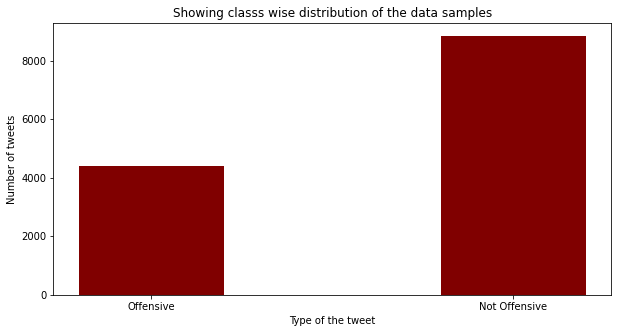

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Offensive':4400, 'Not Offensive':8840}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Type of the tweet")
plt.ylabel("Number of tweets")
plt.title("Showing classs wise distribution of the data samples")
plt.show()

In [ ]:
H1traintext = np.array(H1train['tweet'])
H1trainlabel = np.array(H1train['label'])
# for i in range(len(H1traintext)):
  # H1traintext[i]=preprocess(H1traintext[i])
print(H1traintext.shape)
print(H1trainlabel.shape)
traintext, testtext, trainlabel, testlabel = train_test_split(H1traintext,H1trainlabel,test_size=0.2)

print(traintext.shape)
print(trainlabel.shape)
print(testtext.shape)
print(testlabel.shape)

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def outputscore(txt):
  txt = preprocess(txt)
  encoded_input = tokenizer(txt, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  if scores[0]>0.5:
    return 1
  return 0

(13240,)
(13240,)
(10592,)
(10592,)
(2648,)
(2648,)


In [ ]:
# prediction = []
# for i in range(len(testtext)):
#   txt = testtext[i]
#   # print(txt)
#   prediction.append(outputscore(txt))
#   if (i%500==0):
#     print(i)
#   # print(prediction[i])

# f1_score(testlabel,prediction,average='macro')

In [ ]:
#tf-idf svc 0.701
#roberta(pt) 0.839
#roberta(pt)+MLP 0.847

In [ ]:
def outputontest(test_data):
  txts = []
  ids = []
  labels = []
  for i in range(len(test_data)):
    txt = test_data['tweet'][i]
    labels.append(outputscore(txt))
    txtid = test_data['id'][i]
    txts.append(txt)
    ids.append(txtid)
  # labels = model.predict(txts)
  df = pd.DataFrame(list(zip(labels, ids)),columns =['label', 'id'])
  return df

In [ ]:
prefinal = outputontest(H1test)

In [ ]:
final = prefinal.copy()
final['label']=final['label'].replace([0,1],[1,0])
final0 = final[final['label']==0]
final0.shape

(208, 2)

In [ ]:
final.to_csv('output4.csv',index=False)

In [ ]:
def form_data(traintext,trainlabel):
  """
  Input a data frame and return the dataloder.
  """
  samples = []

  for i in range(len(traintext)):
    tweet = traintext[i]
    tweet = preprocess(tweet)
    lbl = trainlabel[i]
    samples.append(InputExample(texts=[tweet], label = lbl))
  
  dataloader = DataLoader(samples, shuffle=True, batch_size=32)

  return dataloader

In [ ]:
train_dataloader = form_data(traintext,trainlabel)

In [ ]:
# from transformers import RobertaForMaskedLM

# MODEL = f"valurank/distilroberta-offensive"
MODEL = f'cardiffnlp/twitter-roberta-base-offensive'

#Using a base word embedding model
base_model = models.Transformer(MODEL)
# base_model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# base_model = BertForMaskedLM.from_pretrained(MODEL)

#Using a pooling layer over the embeddings
layer_pooling = models.Pooling(base_model.get_word_embedding_dimension())

#Activation function used = tanh
layer_dense = models.Dense(
    in_features = layer_pooling.get_sentence_embedding_dimension(),
    out_features =300 ,activation_function = torch.nn.Tanh())

layer_dense2 = models.Dense(
    in_features = 300,
    out_features =100 ,activation_function = torch.nn.Tanh()
#Combining
model3 = SentenceTransformer(modules=[base_model, layer_pooling, layer_dense])

loss = losses.BatchAllTripletLoss(model=model3)

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-offensive were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
model3.train()
model3.fit(train_objectives=[(train_dataloader,loss)], epochs=2) 

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/331 [00:00<?, ?it/s]

Iteration:   0%|          | 0/331 [00:00<?, ?it/s]

In [ ]:
# # model4 = AutoModelForSequenceClassification.from_pretrained(model3)
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# def outputscore(txt):
#   txt = preprocess(txt)
#   encoded_input = tokenizer(txt, return_tensors='pt')
#   output = model3.encode
#   scores = output[0][0].detach().numpy()
#   scores = softmax(scores)
#   if scores[0]>0.5:
#     return 1
#   return 0

In [ ]:
# tw1 = testtext[0]
# tw1 = preprocess(tw1)
# model3.encode(tw1)

In [ ]:
# prediction = []
# for i in range(len(testtext)):
#   txt = testtext[i]
#   # print(txt)
#   prediction.append(outputscore(txt))
#   if (i%500==0):
#     print(i)
#   # print(prediction[i])

# f1_score(testlabel,prediction,average='macro')

In [ ]:
ttinput = []
tlinput = []
for i in range(len(traintext)):
  txt = traintext[i]
  txt = preprocess(txt)
  if (i%1000==0):
    print(i)
  ttinput.append(model3.encode(txt))
  tlinput.append(trainlabel[i])

from sklearn.svm import SVC

clf = SVC()
clf.fit(ttinput,tlinput)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


SVC()

In [ ]:
testtext[i]

'@USER @USER Loool 🤣🤣🤣😂🤣🤣🤣😂😂😂😂   💜 @USER you are playing waaaay too rough here. 💀   I can’t stop 🛑 laughing 😂 #thankyou'

In [ ]:
len(model3.encode(testtext[i]))

300

In [ ]:
tetinput = []
telinput = []
for i in range(len(testtext)):
  txt = testtext[i]
  txt = preprocess(txt)
  tetinput.append(model3.encode(txt))
  telinput.append(testlabel[i])

predictions = clf.predict(tetinput)

In [ ]:
f1_score(predictions,telinput,average='macro')

0.8363252731320872

In [ ]:
tetinput = []
idinput = []
for i in range(H1test.shape[0]):
  txt = H1test['tweet'][i]
  txt = preprocess(txt)
  tetinput.append(model3.encode(txt))
  idinput.append(H1test['id'][i])

fdictions = clf.predict(tetinput)

In [ ]:
fdictions=list(fdictions)
df = pd.DataFrame(list(zip(fdictions, idinput)),columns =['label', 'id'])

In [ ]:
df2 = df.copy()
df2['label']=df2['label'].replace([0,1],[1,0])
df21 = df2[df2['label']==0]
df21.shape

(201, 2)

In [ ]:
df2.to_csv('output5.csv',index=False)